# Biodiversity Intactness Index change in Phoenix subdivision
Amanda Herbst, MEDS '24

**Link to GitHub repository:** https://github.com/amandaherbst/eds220-phx-biodiversity-loss

## About

### Purpose
In 2021, Maricopa County, which encompasses the Phoenix metropolitan area, was the US county that added the most developed land since 2001. Urban sprawl creates pressure on biodiversity and natural areas. In this notebook we will explore a dataset showing values for a biodiversity intactness index (BII) to find changes in this BII around the Phoenix area from 2017 to 2020. 

### Analysis Highlights
- Visualize raster data
- Accessing MPC STAC
- Masking, clipping raster data
- Importing, manipulating xArray.DataArray

### Dataset Descriptions

**(1) Arizona County Subdivision TIGER/Line Shapefiles**

Shapefiles from the United States Census Bureau of all counties in the state of Arizona.

**(2) Biodiversity Intactness Index (BII) raster data**

Datasets estimating terrestrial Biodiversity Intactness as 100-meter gridded maps for the years 2017-2020. The datasets in this STAC Collection build on past studies that map Biodiversity Intactness using the PREDICTS database of spatially referenced observations of biodiversity across 32,000 sites from over 750 studies. Biodiversity intactness is estimated as a combination of two metrics: Abundance, the quantity of individuals, and Compositional Similarity, how similar the composition of species is to an intact baseline. Linear mixed effects models are fit to estimate the predictive capacity of spatial datasets of human pressures on each of these metrics and project results spatially across the globe.

### References

Microsoft Planetary Computer. *Biodiversity Intactness* [Dataset]. Available from https://planetarycomputer.microsoft.com/dataset/io-biodiversity. Accessed 6 December 2023

US Census Bureau, Geography Division (2022). *Arizona Census County Subdivision 2022 TIGER Shapefiles* [Data File]. Available from https://www.census.gov/cgi-bin/geo/shapefiles/index.php?year=2022&layergroup=County+Subdivisions. Accessed 6 December 2023

## Import libraries and functions:

In [1]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches # for creating legends

import contextily as ctx #for adding basemaps

import xarray as xr
import rioxarray as rioxr
from shapely.geometry import box

import pystac_client
import planetary_computer

## Phoenix subdivision -- Geographical Context

Load Arizona county shapefiles and select "Phoenix." We will use the geometry for plotting and clipping other rasters.

Below is the Phoenix polygon over a map of the area in Arizona acquired from Esri for geographical context.

In [2]:
# counties shapefile
az_counties = gpd.read_file('data/tl_2022_04_cousub/tl_2022_04_cousub.shp')
# phoenix polygon
phx = az_counties[az_counties.NAME == "Phoenix"]

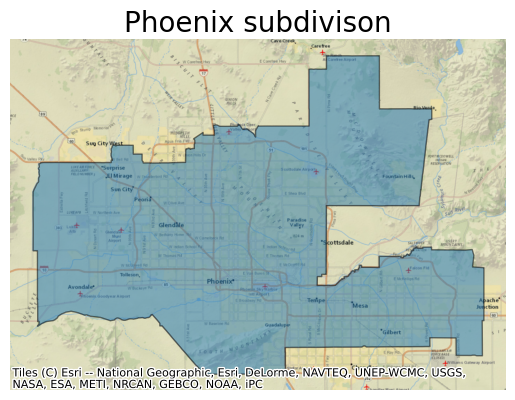

In [3]:
# plot phoenix with geographical context
fig, ax = plt.subplots()

# convert to epsg 2857 for compatability with basemaps
(phx.to_crs(epsg=3857)
 .plot(ax = ax, figsize = (7,7), alpha = 0.5, edgecolor = 'k'))

# add basemap
ctx.add_basemap(ax=ax, source=ctx.providers.Esri.NatGeoWorldMap)

ax.set_title('Phoenix subdivison', fontdict = {'fontsize':'20'})
ax.set_axis_off()

## Biodiversity Intactness Index (BII)

Load BII data from the MPC STAC catalog with coordinates defining a bounding box around Phoenix and selecting years 2017-2020.

In [4]:
# open catalog
catalog = pystac_client.Client.open(
    "https://planetarycomputer.microsoft.com/api/stac/v1",
    modifier=planetary_computer.sign_inplace,
)

# coords defining bbox around phoenix
bbox = [-112.826843, 32.974108, -111.184387, 33.863574]

# search
search = catalog.search(
    collections = ['io-biodiversity'],
    bbox = bbox,
    datetime = '2017/2020'
)

Check out the items in our search! Since we selected a range of years we got 4 items, but we only want 2: 2017 and 2020

In [5]:
items = search.item_collection()
items

id: bii_2020_34.74464974521749_-115.38597824385106_cog
"bbox: [-115.3859782, 27.565314, -108.2066425, 34.7446497]"
datetime: None
proj:epsg: 4326
"proj:shape: [7992, 7992]"
end_datetime: 2020-12-31T23:59:59Z
"proj:transform: [0.0008983152841195215, 0.0, -115.38597824385106, 0.0, -0.0008983152841195215, 34.74464974521749, 0.0, 0.0, 1.0]"
start_datetime: 2020-01-01T00:00:00Z
https://stac-extensions.github.io/projection/v1.0.0/schema.json
https://stac-extensions.github.io/raster/v1.1.0/schema.json
https://stac-extensions.github.io/version/v1.1.0/schema.json


Looking at the collection of items, it looks like the 4th item references the 2017 raster and the 1st item references the 2020 item

In [6]:
item_2017 = items[3]
item_2020 = items[0]

phx_17 = rioxr.open_rasterio(item_2017.assets['data'].href)
phx_20 = rioxr.open_rasterio(item_2020.assets['data'].href)

In [7]:
print("phx 2017 bii crs: ", phx_17.rio.crs)
print("phx 2020 bii crs: ", phx_20.rio.crs)
print("phx county crs: ", phx.crs)

phx 2017 bii crs:  EPSG:4326
phx 2020 bii crs:  EPSG:4326
phx county crs:  EPSG:4269


In [8]:
phx = phx.to_crs(phx_17.rio.crs)
# check
print('matched crs?',  phx.crs == phx_17.rio.crs)

matched crs? True


In [9]:
# clip
# clip rasters to phx
phx_17_clip = phx_17.rio.clip(phx.geometry).squeeze().drop('band')
phx_20_clip = phx_20.rio.clip(phx.geometry).squeeze().drop('band')

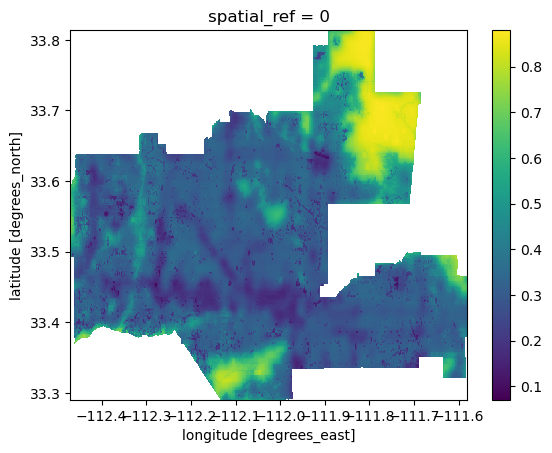

In [10]:
phx_17_clip.plot.imshow()

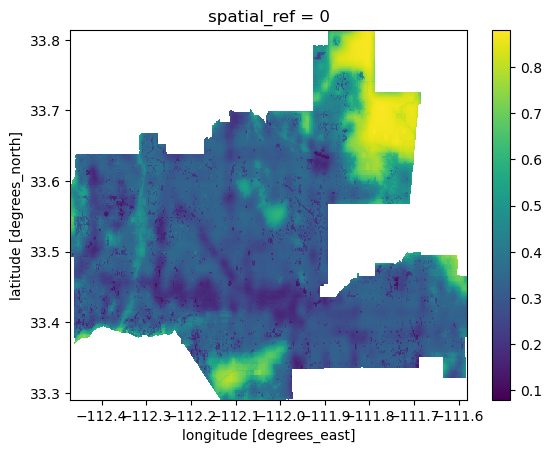

In [11]:
phx_20_clip.plot.imshow()

## Percentage area of phoenix subdivison with BII of at least 0.75 in 2017 and 2020

- Let x be an xarray.DataArray. We can select all the values greater than n by simply doing x>n. This will return an xarray.DataArray with boolean values. You can then transform this into an xarray.DataArray with 0s and 1s (instead of True/False) by casting it as type ‘int’. 
- To calculate the percentage area: (pixels in class)/(total pixels) * 100. 


In [12]:
# create mask with BII of at least 0.75
phx_17_mask = (phx_17_clip >= 0.75).astype(int)
phx_20_mask = (phx_20_clip >= 0.75).astype(int)

# count the number of pixels labeled 0 and labeled 1
code, pixels_17 = np.unique(phx_17_mask, return_counts = True)
code, pixels_20 = np.unique(phx_20_mask, return_counts = True)

# organize pixel counts 
d = {
    'code': code,
    'num_pixels_17': pixels_17,
    'num_pixels_20': pixels_20
}

pix_counts = pd.DataFrame(d)
pix_counts

,code,num_pixels_17,num_pixels_20
0,0,553037,555184
1,1,24133,21986


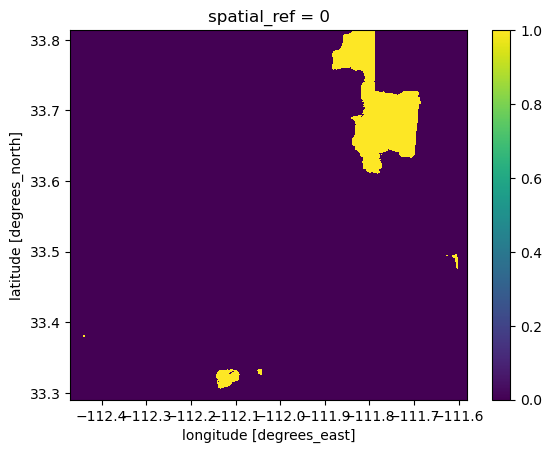

In [13]:
phx_17_mask.plot()

In [14]:
# total count pixels in phoenix
# NA pixels in the clip are transformed to 0s when making the mask
tot_phx_17_pixels = phx_17_clip.count().item()
tot_phx_20_pixels = phx_20_clip.count().item()

In [15]:
# calculate percentage of area using the pixels outputs from above
pct_area_17 = pixels_17[1]/(tot_phx_17_pixels)*100
pct_area_20 = pixels_20[1]/(tot_phx_20_pixels)*100

print(round(pct_area_17,2), "% of the Phoenix subdivision had a BII of at least 0.75 in 2017.")
print(round(pct_area_20,2), "% of the Phoenix subdivision had a BII of at least 0.75 in 2020.")

7.13 % of the Phoenix subdivision had a BII of at least 0.75 in 2017.
6.49 % of the Phoenix subdivision had a BII of at least 0.75 in 2020.


## Visualization of biodiversity loss in Phoenix

Plot BII lost on top of 2020 BII

array([ 1., nan])

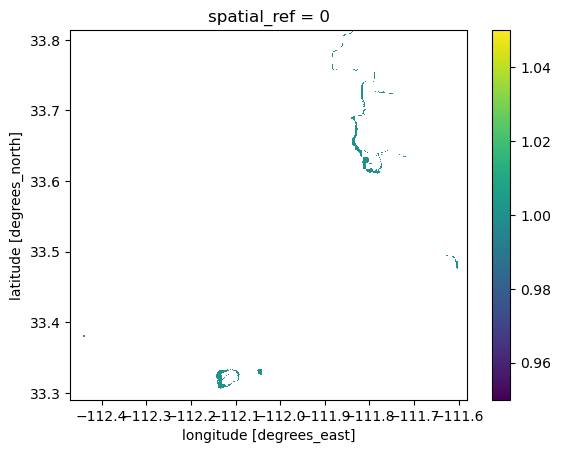

In [16]:
# calculate biodiversity lost by subrtracting 2020 mask from 2017
# this way, any pixel that lost biodiversity will be designated by a 1
area_loss = (phx_17_mask - phx_20_mask)

# convert -1 and 0 values to nan values
area_loss = area_loss.where(area_loss == 1)
area_loss.plot()
np.unique(area_loss)

## Visualization of Biodiveristy Loss in Phoenix from 2017 to 2020

Combing all of our calculations/visualizations into one final visualization!

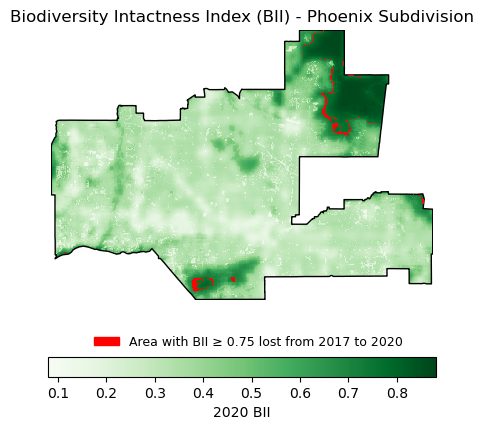

In [17]:
# create final plot figure and axes
fig, ax = plt.subplots(figsize = (5, 5))

#-------------------------------------------------------------------------------------------
# plot 2020 phoenix BII
phx_20_clip.plot(ax = ax,
                 cmap = "Greens",
                 cbar_kwargs={'orientation':'horizontal',
                            'label':'2020 BII'})
#-------------------------------------------------------------------------------------------
# add outline of phoenix subdivision
phx.plot(ax = ax,
         color = "none",
         edgecolor = 'black')
#-------------------------------------------------------------------------------------------
# add area with high biodiversity lost from 2017 to 2020
area_loss.plot(ax = ax,
               cmap = "brg", 
               add_colorbar=False)

# create patch for legend
loss_patch = mpatches.Patch(color = 'red',
                           label = 'Area with BII ≥ 0.75 lost from 2017 to 2020')
#-------------------------------------------------------------------------------------------
# add legend indicating what the red is
ax.legend(handles = [loss_patch],
         frameon = False,
         loc = (0.1,-0.2),
         fontsize = 9)

# turn off lat/lon axes
ax.axis('off')

# add plot title
plt.title('Biodiversity Intactness Index (BII) - Phoenix Subdivision')
plt.show()
